In [43]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from PIL import Image
import numpy as np
import glob
import os
import warnings
from matplotlib import pyplot as plt
import cv2
import pandas as pd

%matplotlib inline
%config InlineBackend.figure_formats = 'retina'
warnings.filterwarnings("ignore")

In [3]:
train_path = "Classification_data/train/"
test_path = "Classification_data/test/"

In [4]:
class2ind = {}
ind2class = {}

In [5]:
for i, folder in enumerate(os.listdir(train_path)):
   ind2class[i]=folder

In [6]:
class2ind={ind2class[i]: i  for i in range(len(ind2class))}

In [7]:
class2ind

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [87]:
def get_data(path):
    data = []
    labels = []
    for folder in glob.glob(path + '/*'):
        for filename in glob.glob(folder + "/*.jpg"):
        # print(filename)
            image = cv2.imread(filename)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            data.append(image)
            label = filename.split('\\')[-2]
            labels.append(class2ind[label])

    return data, labels


In [88]:
train_data, train_labels = get_data(train_path)
test_data, test_labels = get_data(test_path)

### Create custom dataset of images

In [89]:
class ImageDataset(Dataset):
    def __init__(self, data, labels, transform=None, target_transform=None):
        self.img_data = data
        self.img_labels = labels
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        image = self.img_data[idx]
        label = self.img_labels[idx]
        if self.transform:
            image =self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [90]:
train_dataset = ImageDataset(train_data, train_labels)

In [91]:
train_dataset

In [92]:
image, label = train_dataset[14000]

In [93]:
print(image)

[[[246 255 251]
  [219 225 221]
  [175 174 170]
  ...
  [117 150 167]
  [141 177 201]
  [102 142 167]]

 [[238 249 243]
  [241 247 243]
  [190 189 187]
  ...
  [ 86 117 135]
  [123 159 181]
  [154 192 215]]

 [[231 240 237]
  [235 240 236]
  [126 125 123]
  ...
  [154 181 200]
  [180 212 233]
  [174 209 231]]

 ...

 [[103  98 104]
  [104  99 105]
  [104 102 107]
  ...
  [ 64  64  72]
  [ 43  44  49]
  [ 49  50  55]]

 [[106 101 107]
  [106 101 107]
  [106 104 109]
  ...
  [ 59  60  65]
  [ 60  61  66]
  [ 33  34  39]]

 [[112 107 113]
  [110 105 111]
  [106 104 109]
  ...
  [ 60  61  66]
  [ 68  69  74]
  [ 28  29  34]]]


In [94]:
image.dtype

dtype('uint8')

In [95]:
def visualise_images(dataset):
    fig, axs = plt.subplots(2, 5, figsize=(20, 10))
    idx = np.random.randint(0, len(dataset), 10)
    for i, index in enumerate(idx):
        axs[i//5, i%5].imshow(dataset[index][0])
        axs[i//5, i%5].axis("off")
        title = ind2class[dataset[index][1]]
        axs[i//5, i%5].set_title(f"Class {title}")

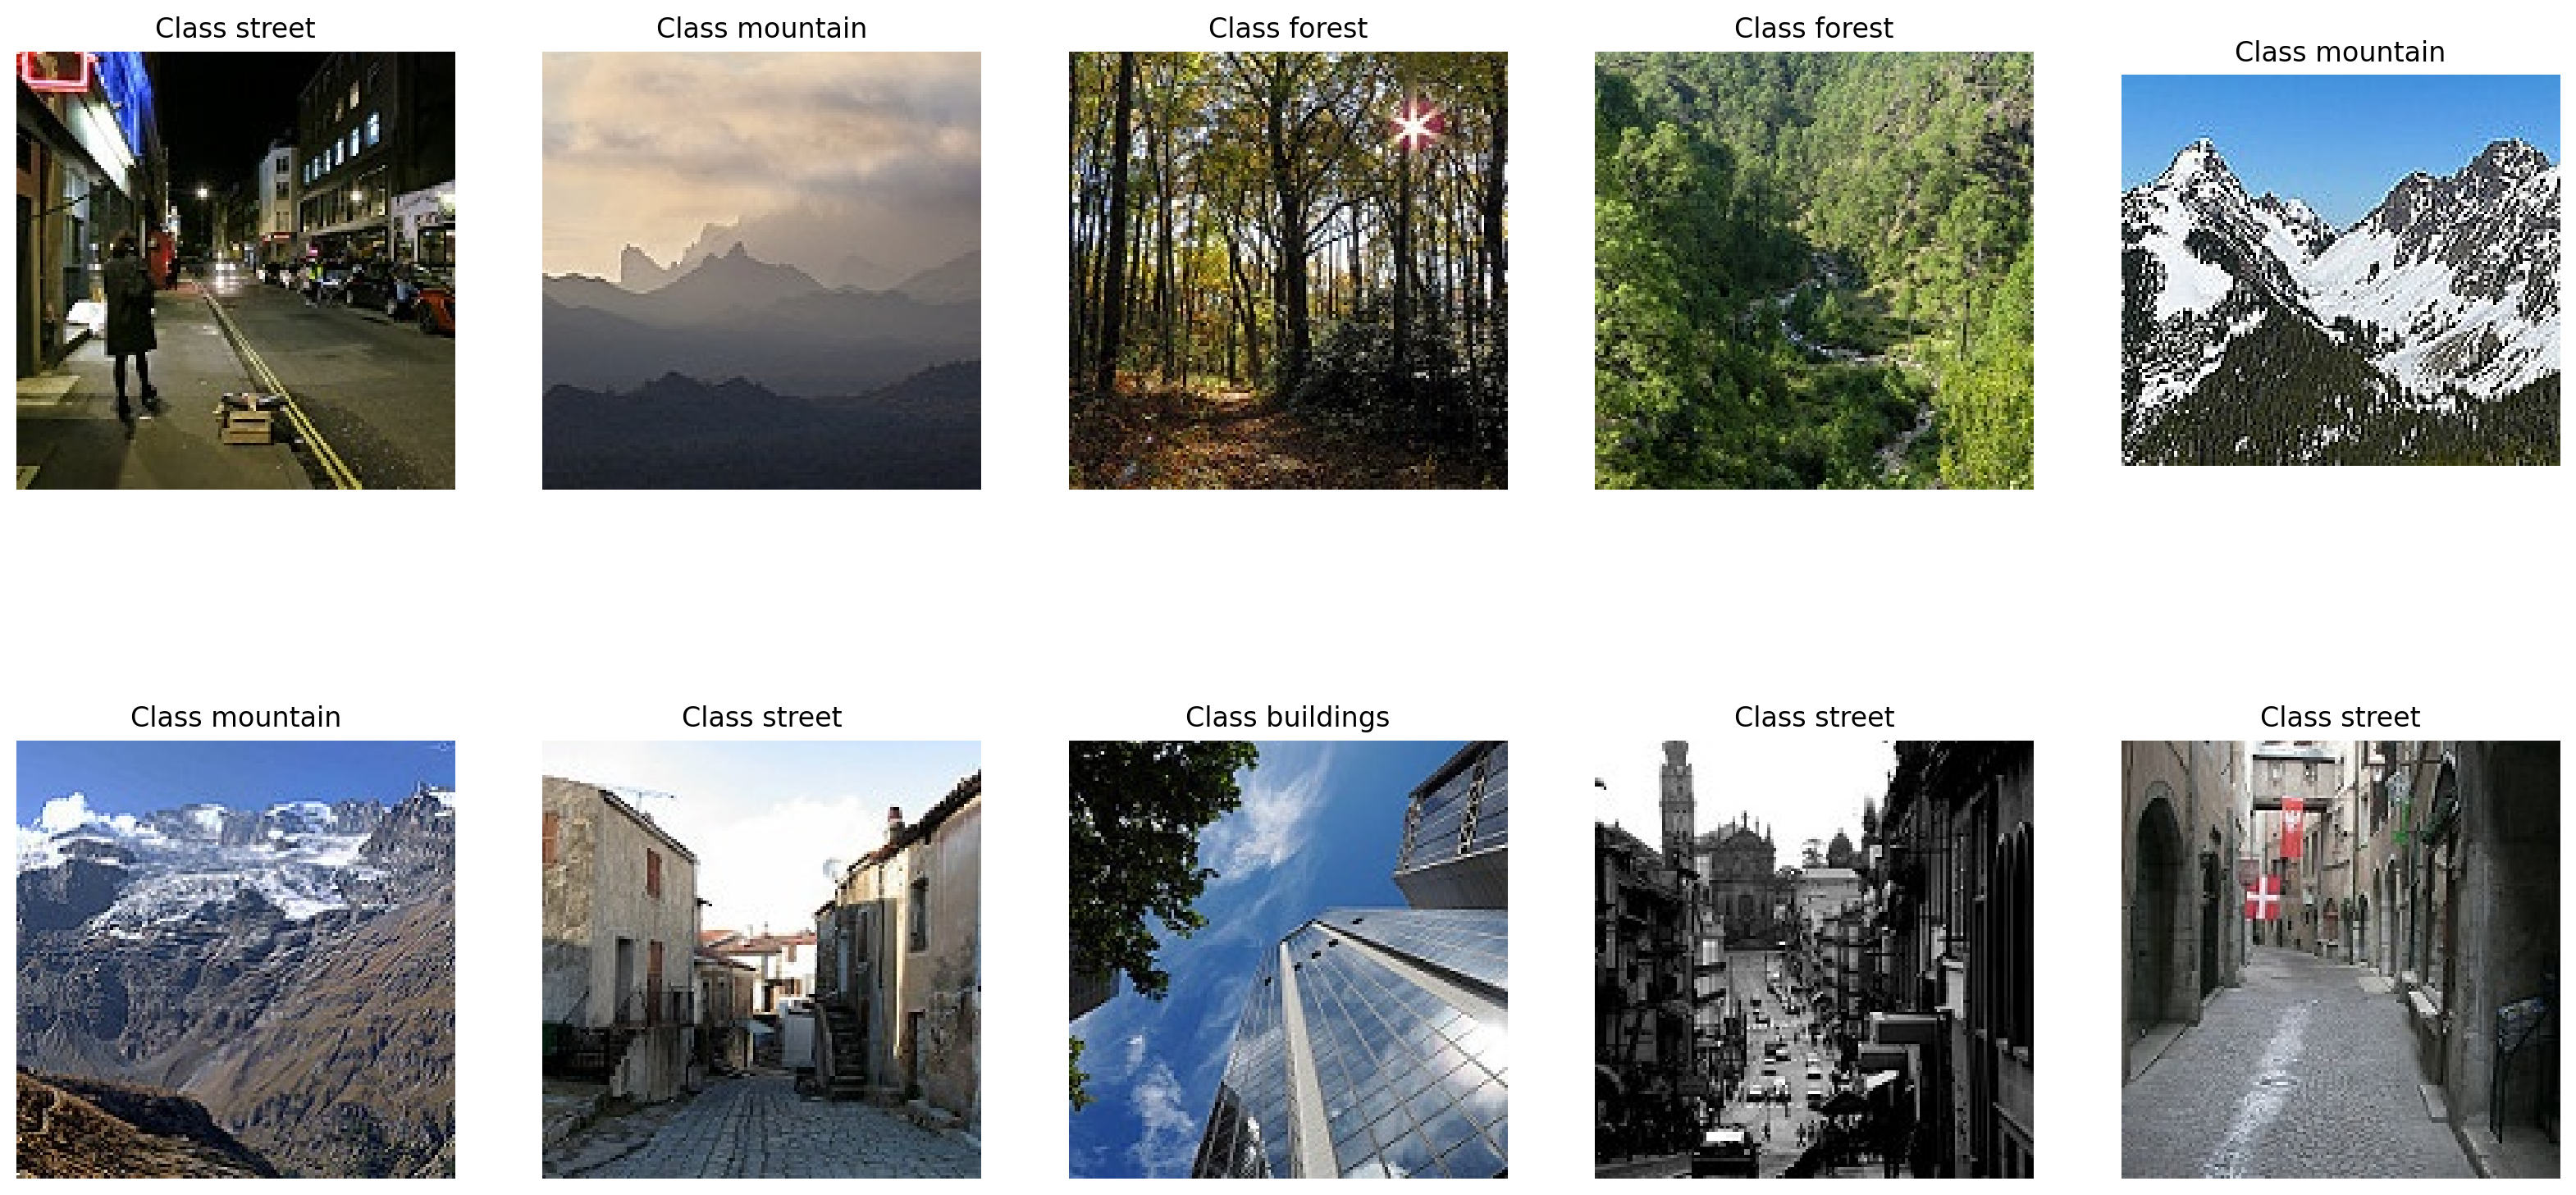

In [96]:
visualise_images(train_dataset)

In [97]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.ConvertImageDtype(torch.float32),
        transforms.CenterCrop((150, 150)),
        transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
    ]
)

In [104]:
train_dataset = ImageDataset(train_data, train_labels, transform=transform)
test_dataset = ImageDataset(test_data, test_labels, transform=transform)

In [103]:
train_dataset[0][0].shape

torch.Size([3, 150, 150])